In [1]:
import test_config as cfg
import numpy as np

%matplotlib inline
import matplotlib.pyplot as plt
import os, os.path
import pickle
import io

import skimage
import skimage.io, skimage.transform, skimage.filters
import scipy.ndimage

import sys
sys.path.append(r'../src/')

import importlib
import transform
import filters
import local_radon
import skew_line
importlib.reload(transform)
importlib.reload(filters)
importlib.reload(local_radon)
importlib.reload(skew_line)

<module 'skew_line' from '../src\\skew_line.py'>

D:/Data/bujo_sample\20190309_125151.jpg


C:\Anaconda3\lib\site-packages\skimage\transform\_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
C:\Anaconda3\lib\site-packages\skimage\transform\radon_transform.py:69: UserWarning: Radon transform: image must be zero outside the reconstruction circle
  warn('Radon transform: image must be zero outside the '


Text angles is 0.0
Text line delta is 9
Wall time: 978 ms


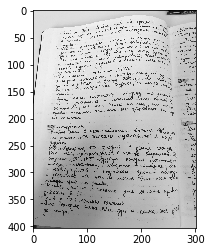

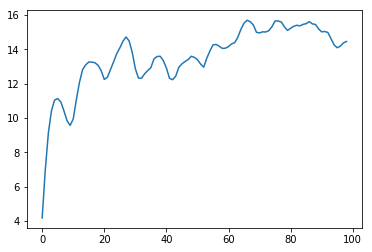

In [2]:
%%time
src_fname = os.path.join(cfg.sample_path, os.listdir(cfg.sample_path)[6])
print(src_fname)
src = skimage.io.imread(src_fname, as_grey=True)

src2 = skimage.transform.rescale(src, scale=0.05)

text_angle = transform.get_text_angle(src2)
print('Text angles is {}'.format(text_angle[0][0]))

src3 = skimage.transform.rotate(skimage.transform.rescale(src, scale=0.1), -90.0-text_angle[0][0], resize=True)
plt.figure()
plt.imshow(src3, cmap='gray')

text_line_delta, text_line_deltas = transform.get_text_line_delta(src3)
plt.figure()
plt.plot(text_line_deltas)
print('Text line delta is {}'.format(text_line_delta))

C:\Anaconda3\lib\site-packages\skimage\transform\_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


[(-1.5466302294595904, -64.0, 0, 162, 1677)]
Wall time: 167 ms


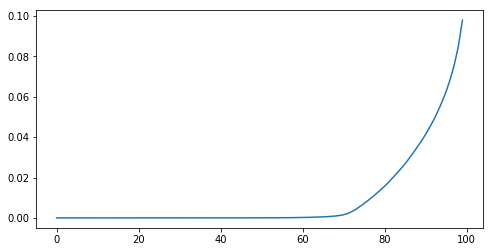

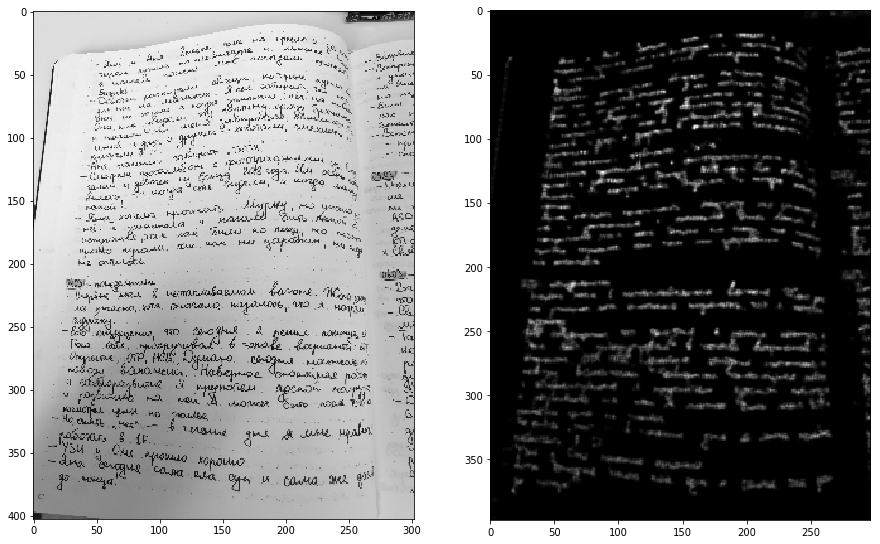

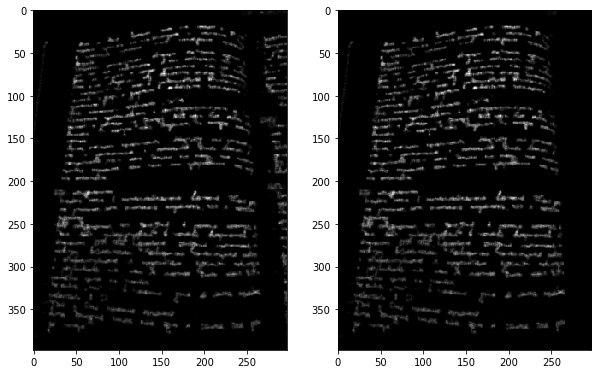

In [3]:
%%time
src4 = transform.filter_variance(src3, (text_line_delta//2, text_line_delta//2), 50, 50)
text_cutoff = np.percentile(src4, 90)/2

src5 = skimage.transform.rescale(src4>text_cutoff, scale=0.25)>0.0
src6 = skimage.filters.gaussian(src5, sigma=0.2)>0.4

vsplits = transform.search_region_vsplit(src6, np.pi*3/8, num_angles=131,
                                         window_size_1d=15, max_value=2, zero_threshold=10,
                                         min_split_abs=100, max_split_pct=0.10)

src7 = transform.erase_regions(src4, vsplits, dsz=4)


plt.figure(figsize=(8,4))
plt.plot(np.percentile(src4, range(100)))

plt.figure(figsize=(15,15))
plt.subplot(121)
plt.imshow(src3, cmap='gray')
plt.subplot(122)
plt.imshow(src4, cmap='gray')

print(vsplits)

plt.figure(figsize=(10,10))
plt.subplot(121)
plt.imshow(src4, cmap='gray')
plt.subplot(122)
plt.imshow(src7, cmap='gray')

Wall time: 1.05 s


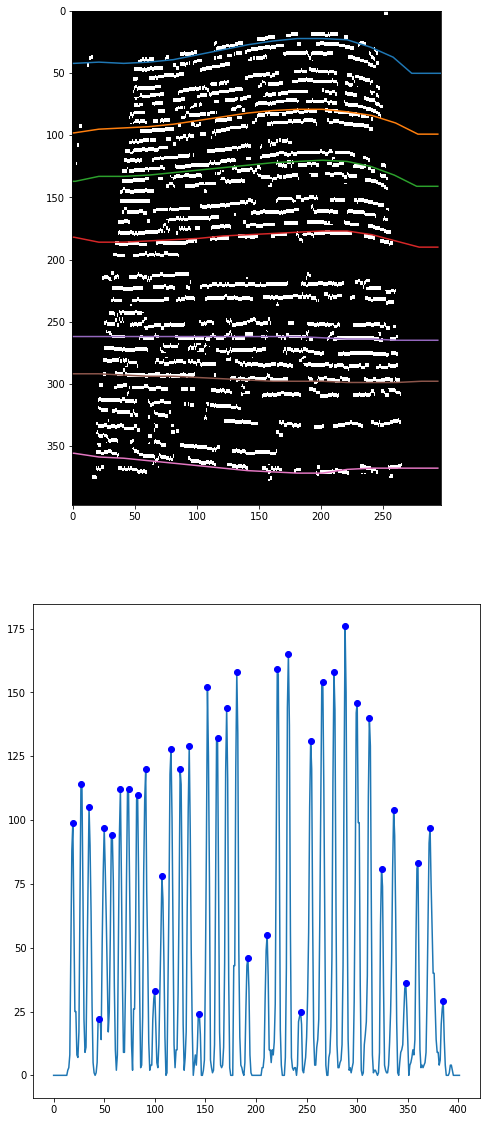

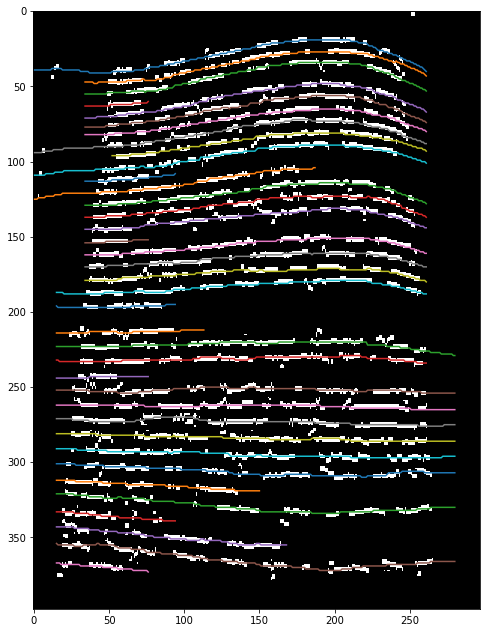

In [4]:
%%time
src8 = filters.local_maxima_v(src7, 1, text_line_delta//2, text_cutoff)*1.0

curves = skew_line.create_support_curves(src8, 20, (40, 50))

ires, imeta = skew_line.integrate_curves(src8, curves)
ids = skew_line.select_line_candidates(ires, text_line_delta//2, min_value=20, minmax_ratio=0.8)

all_curves = []
for i in ids:
    if len(imeta[i])>2:
        tmp_j, tmp_i = skew_line.interpolate_between_curves(np.arange(src8.shape[1]), 0, src8.shape[0]-1, imeta[i][0], imeta[i][1], imeta[i][2])
    else:
        tmp_j, tmp_i = skew_line.offset_curve(np.arange(src8.shape[1]), imeta[i][0], imeta[i][1])
    res_j, res_i = skew_line.optimize_curve(src8, tmp_j, tmp_i, offset=4, min_window=20)
    all_curves.append((res_j, res_i))

plt.figure(figsize=(8,20))
plt.subplot(211)
plt.imshow(src8, cmap='gray')
for crv in curves:
    plt.plot(crv[:,1], crv[:,0])
    
plt.subplot(212)
plt.plot(ires)
for i in ids:
    plt.plot(i, ires[i], 'bo')
    
plt.figure(figsize=(8,20))
plt.imshow(src8, cmap='gray')
for crv_j, crv_i in all_curves:
    plt.plot(crv_j, crv_i)

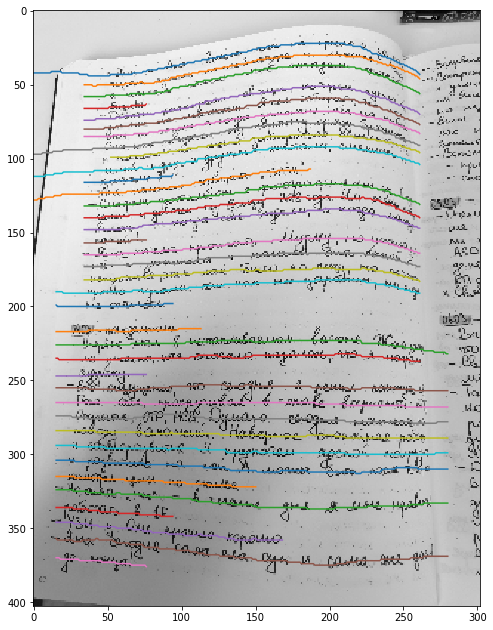

In [5]:
plt.figure(figsize=(8,20))
plt.imshow(src3, cmap='gray')
for crv_j, crv_i in all_curves:
    plt.plot(crv_j, crv_i+text_line_delta//4+1)

In [14]:
def get_closest_local_min(arr1d):
    off_less = np.argmax(arr1d[1:]<arr1d[:-1])    
    msk_min = arr1d[1:]>=arr1d[:-1]
    off = np.argmax(msk_min[off_less:])+off_less
    return off

def get_line_height(src, crv_j, crv_i, max_offset, additive_regularization=0):
    offsets = np.arange(-max_offset, max_offset+1)
    values = np.array([np.sum(src[np.maximum(0, np.minimum(src.shape[0]-1, crv_i+off)), crv_j]) for off in offsets])
    off_r = get_closest_local_min(values[max_offset:]+additive_regularization)
    off_l = get_closest_local_min(values[:(max_offset+1)][::-1]+additive_regularization)
    return (-off_l, off_r)

def reparametrize_by_x(crv_j, crv_i, num_points):
    new_j = np.linspace(np.min(crv_j), np.max(crv_j), num_points)
    new_i = np.interp(new_j, crv_j, crv_i)
    return new_j, new_i

def reparametrize_by_length(crv_j, crv_i, num_points):
    dx2 = np.power(np.abs(crv_j[1:]-crv_j[:-1]), 2.0)
    dy2 = np.power(np.abs(crv_i[1:]-crv_i[:-1]), 2.0)
    crv_len = np.insert(np.cumsum(np.sqrt(dx2+dy2)), 0, 0) #prepend 0
    new_len = np.linspace(0, crv_len[-1], num_points) #parametrization by length
    new_j = np.interp(new_len, crv_len, crv_j)
    new_i = np.interp(new_j, crv_j, crv_i)
    return new_len, new_j, new_i

def extract_line(src, crv_p, crv_j, crv_i, offset):
    height = np.ceil(np.max(offset) - np.min(offset)).astype(int)
    width = np.ceil(np.max(crv_p) - np.min(crv_p)).astype(int)
    res = np.zeros(shape=(height, width))
    
    actual_p = np.arange(width) + np.min(crv_p)
    actual_j = np.floor(np.interp(actual_p, crv_p, crv_j) + 0.5).astype(int)
    actual_i = np.floor(np.interp(actual_p, crv_p, crv_i) + 0.5 + min(offset)).astype(int)
    
    for i in range(height):
        res[i,:] = src[actual_i + i, actual_j]
        
    return res

def extract_line_from_image(img, src, crv_j, crv_i, line_delta, num_points, height_margin=0, filter_offset=None):
    max_offset = 2 * line_delta
    additive_regularization = np.power(np.linspace(0, 2, 2 * line_delta + 1), 2.0)
    use_filter_offset = filter_offset
    if filter_offset is None:
        use_filter_offset = (line_delta//2+1)//2+1
    
    offsets = get_line_height(src, crv_j, crv_i, max_offset, additive_regularization=additive_regularization)
    crv_r = reparametrize_by_x(crv_j, crv_i, num_points)
    crv_l = reparametrize_by_length(*crv_r, num_points)
    sz_factor = img.shape[0] / (src.shape[0] + (use_filter_offset-1)*2)
    crv_q = (crv_l[0]*sz_factor, crv_l[1]*sz_factor, (crv_l[2]+use_filter_offset)*sz_factor)
    
    return extract_line(img, *crv_q, (np.floor(offsets[0]*sz_factor*(1+height_margin)), np.ceil(offsets[1]*sz_factor*(1+height_margin))))

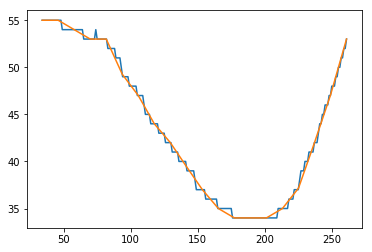

In [7]:
crv = all_curves[2]
crv_r = reparametrize_by_x(*crv, 20)
plt.plot(*crv)
plt.plot(*crv_r)

In [ ]:
max_offset = 2 * text_line_delta
additive_regularization = np.power(np.linspace(0, 2, 2 * text_line_delta + 1), 2.0)

for crv in all_curves[:20]:
    offsets = get_line_height(src7, *crv, max_offset, additive_regularization=additive_regularization)
    crv_r = reparametrize_by_x(*crv, 20)
    crv_l = reparametrize_by_length(*crv_r, 30)
    tmp = extract_line(srcr, crv_l[0], crv_l[1], crv_l[2]+3, offsets, 10)
    #plt.figure(figsize=(20, 20))
    #plt.imshow(tmp, cmap='gray')

C:\Anaconda3\lib\site-packages\skimage\transform\_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


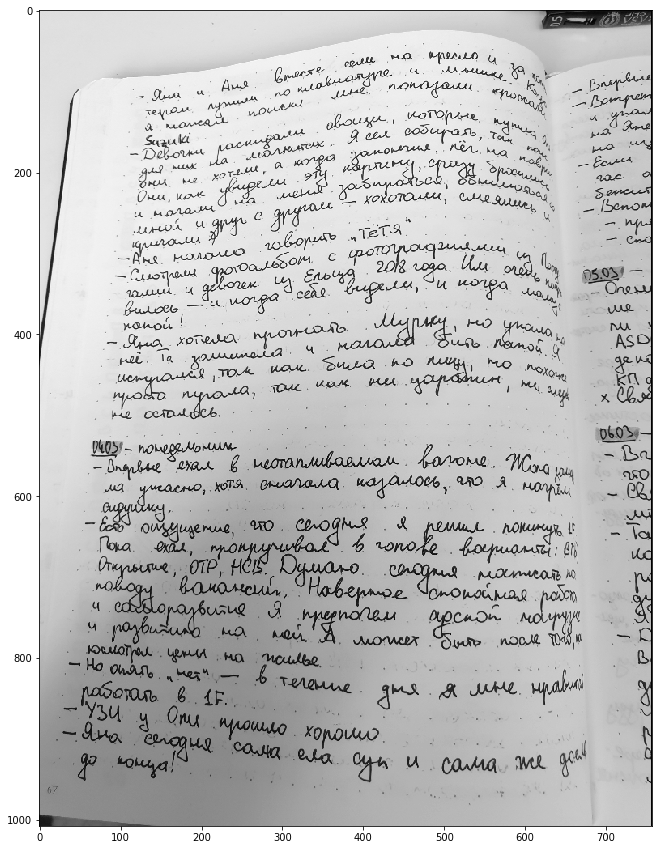

In [8]:
srcr = skimage.transform.rotate(skimage.transform.rescale(src, scale=0.25), -90.0-text_angle[0][0], resize=True)
plt.figure(figsize=(15,15))
plt.imshow(srcr, cmap='gray')

C:\Anaconda3\lib\site-packages\matplotlib\pyplot.py:537: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


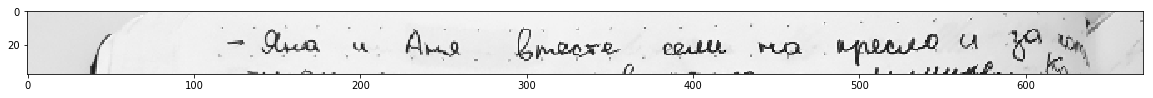

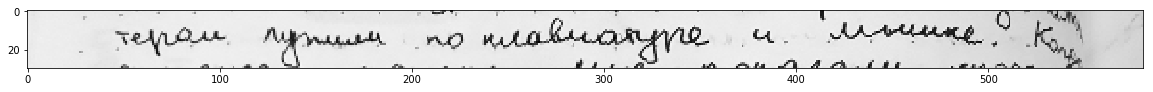

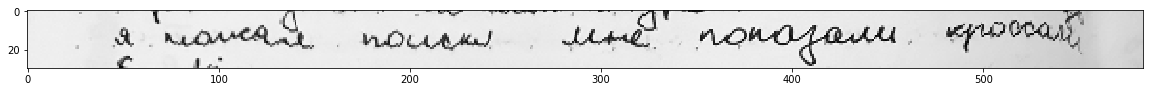

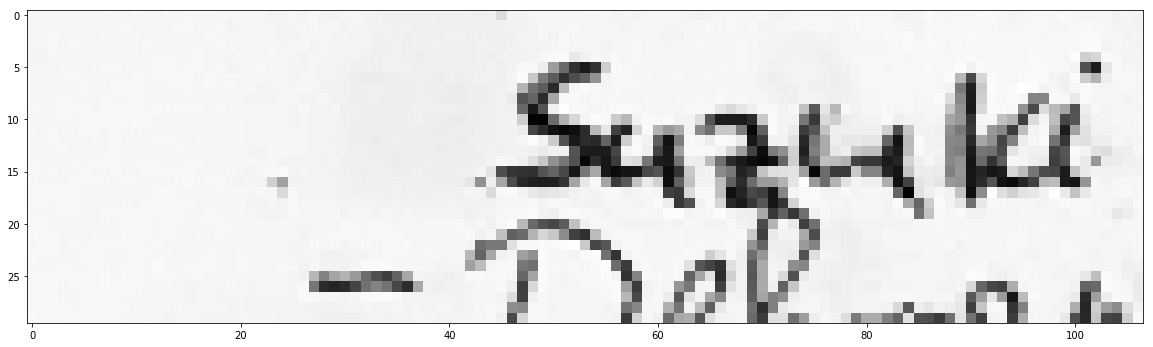

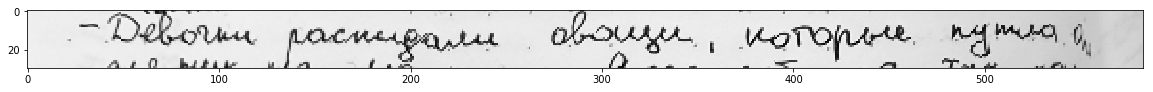

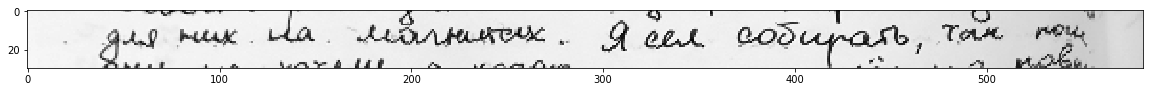

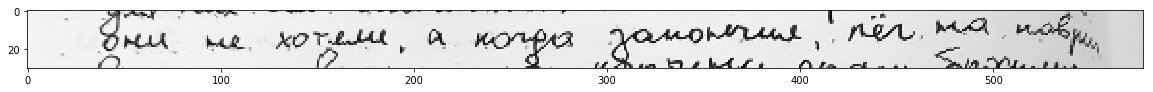

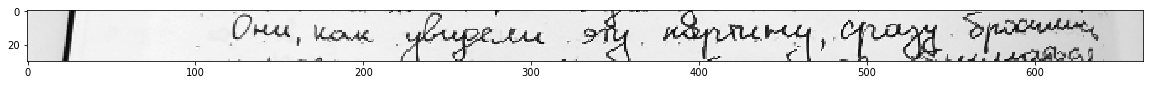

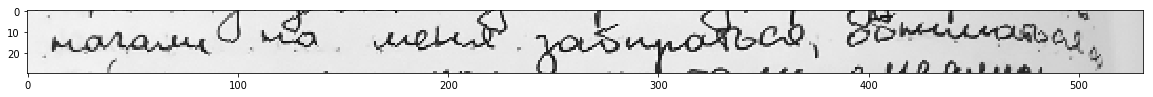

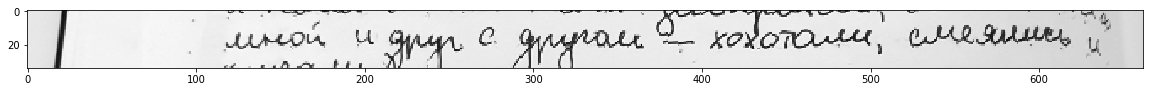

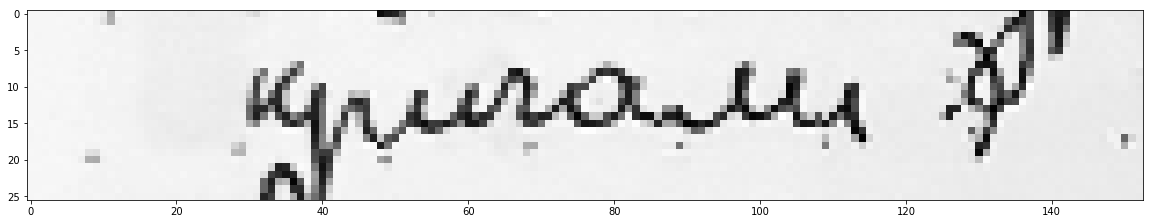

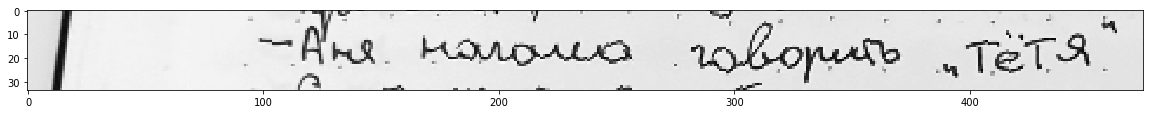

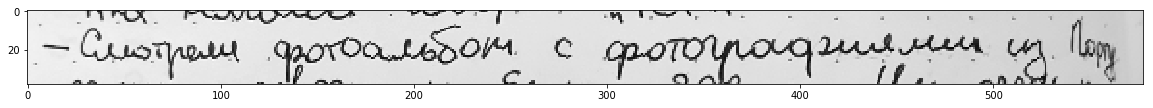

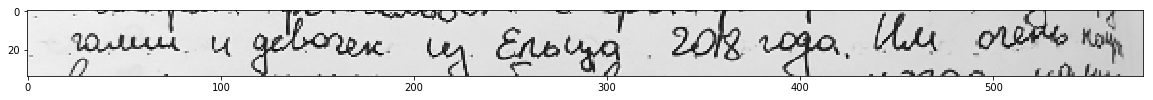

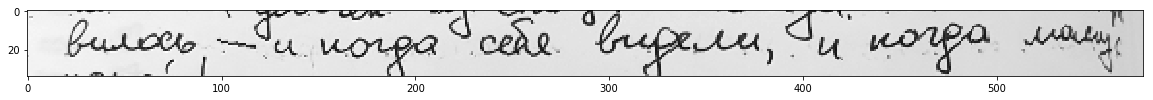

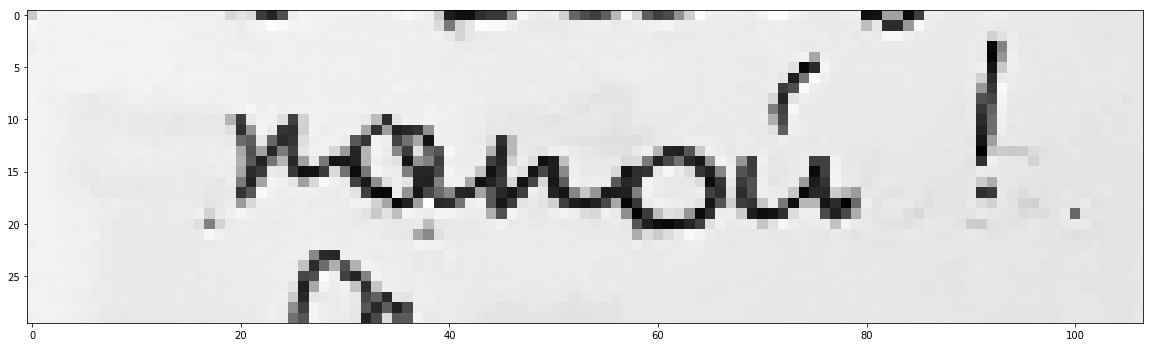

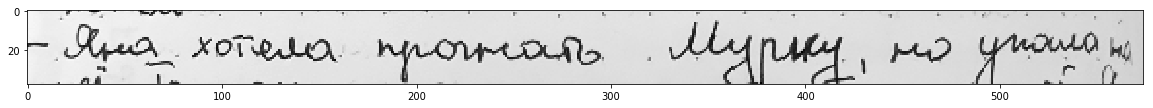

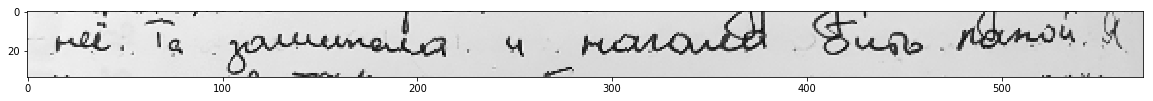

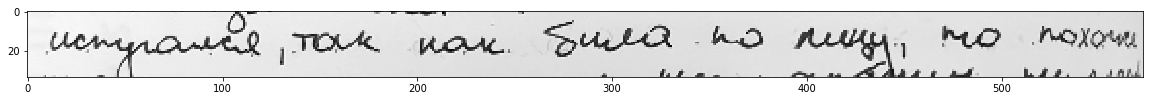

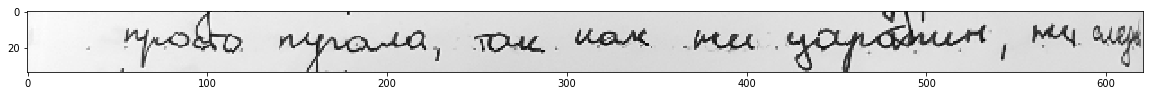

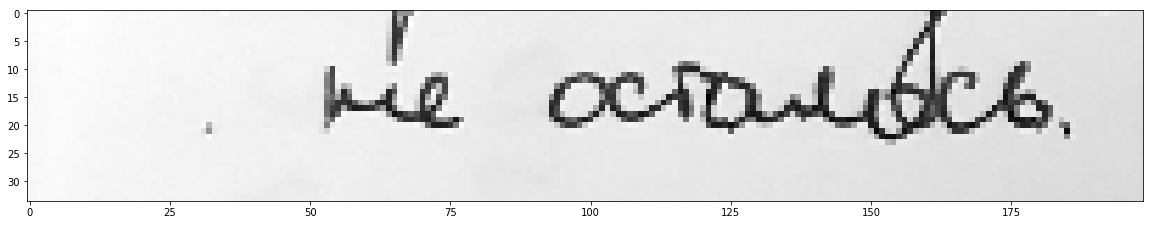

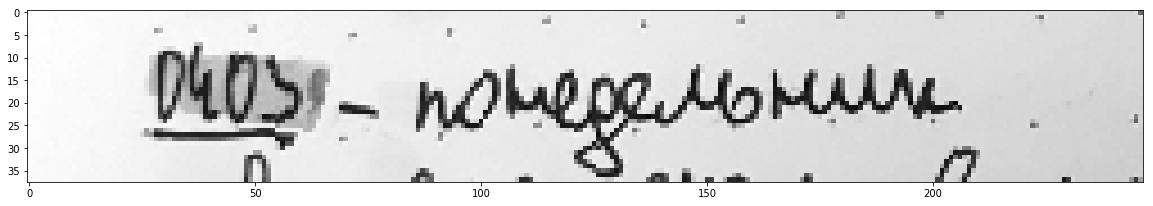

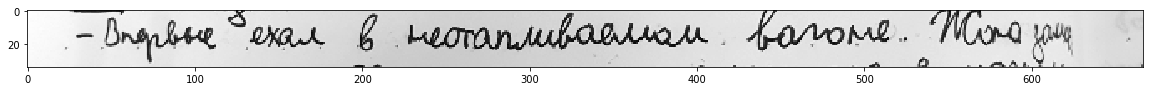

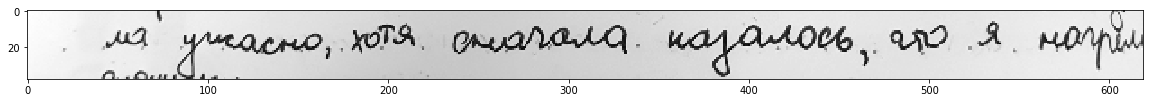

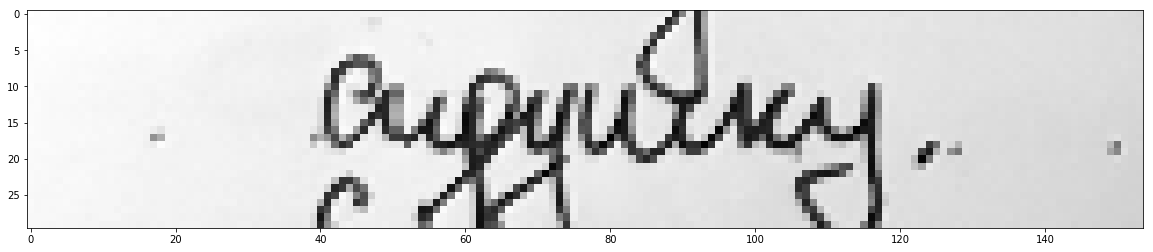

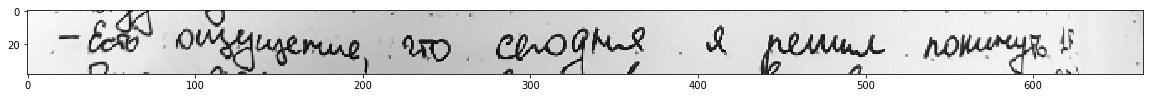

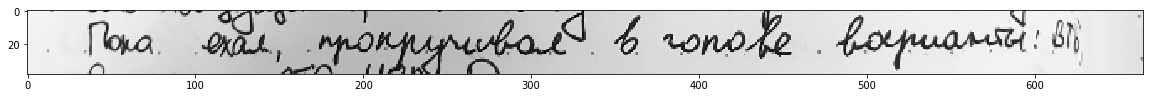

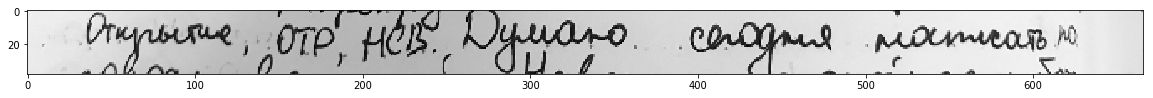

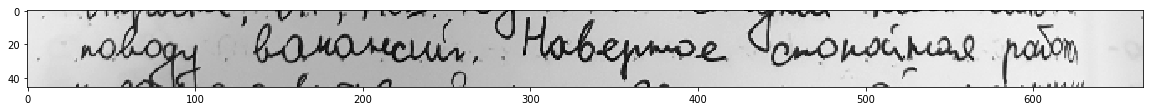

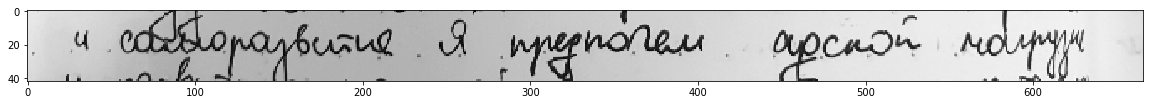

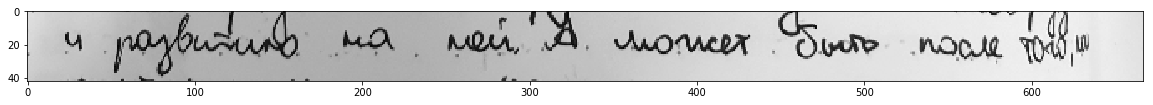

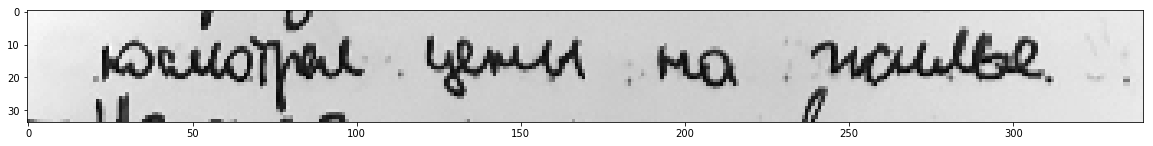

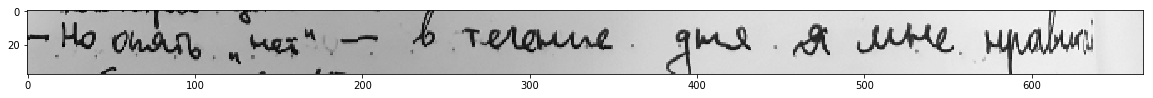

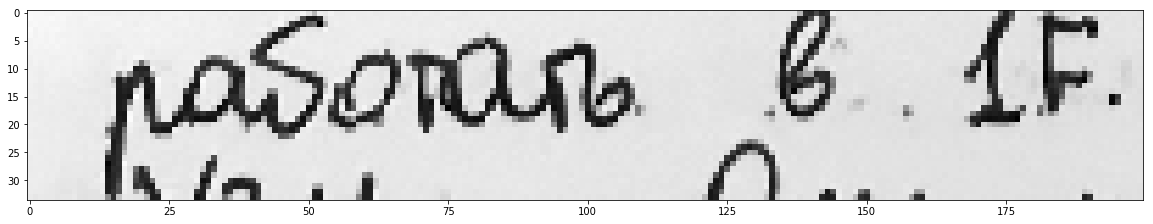

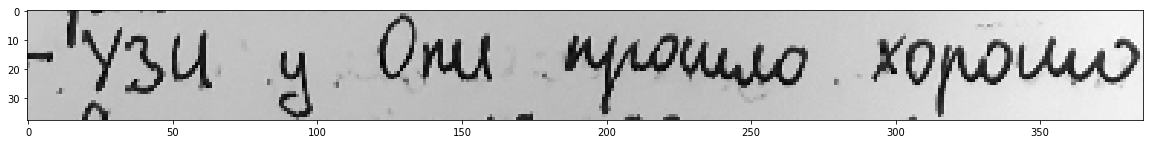

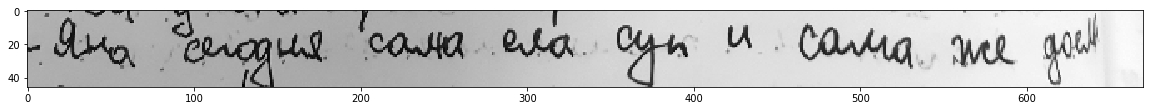

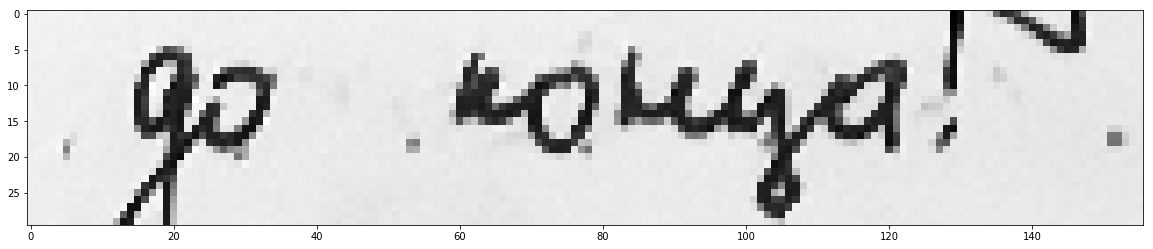

In [17]:
for crv in all_curves:
    plt.figure(figsize=(20,20))
    plt.imshow(extract_line_from_image(srcr, src7, *crv, text_line_delta, 20, height_margin=0.6), cmap='gray')